In [60]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader , WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from PIL import Image
from collections import Counter
from torch.utils.data import TensorDataset
import random


''''We first load the train and test data to check the mean and standard deviation-
as we need to normalize our images and check the count of each class'''

train_data = datasets.ImageFolder(root='./images/train')
test_data = datasets.ImageFolder(root='./images/validation')

#init the lists , so that we can store the mean of all the images and standard deviations
train_mean = []
train_std = []

#iterate through train_data as train_data contain images and labels(no need for labels)
for img, _ in train_data:
  # now we convert the img to numpy array 
    img_np = np.array(img)
    
    # Since our given dataset images are Grayscale it only has 1 channel unlike 3 in RGB
    channel_mean = np.mean(img_np)  
    channel_std = np.std(img_np)   
    #Append it in the lists
    train_mean.append(channel_mean)
    train_std.append(channel_std)
    
#Print the mean of total train_mean and Train_standard_deviation
print("Train Mean:", np.mean(train_mean))
print("Train Std:", np.std(train_std))

#Use counter to count the total samples for each class
class_counts = Counter([label for _, label in train_data.imgs])
print("Original class counts:", class_counts)

Train Mean: 129.19416510989976
Train Std: 13.63471971771445
Original class counts: Counter({3: 6864, 4: 4682, 5: 4638, 2: 3803, 0: 3693, 6: 2905, 1: 336})


In [62]:
'''As we can see from the above class counts, the data is heavily imbalanced and we cannot use it directly in our dataset.
One can undersample the majority class, oversample the minority class or can use Augmentation'''

'''Oversampling minority class can cause overfitting and it did for our dataset, so augmentation is a safe choice.
    Also undersampling the majority class causes loss of important data and after lot of experimentations I have chosen to skip undersampling
'''

#We use augment_transform to add augmented images to include diversity and variablity in our dataset
augment_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Ensure augmented image remains grayscale(not necessary but just for certainty)
    transforms.Resize((48, 48)), # similarly ensured images stay at 48*48 pixels
    
    #keeps our img size at 48*48 pixels and scales them between 0.8 to 1.0 randomly
    transforms.RandomResizedCrop(size=48, scale=(0.8, 1.0)), 
    
    # Performs random rotation between 0 - 30 degrees
    transforms.RandomRotation(degrees=(0, 30)),  
    
    #used multiple random apply so that our augmented data creates wide range of different images
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.4),# p stands for probablity here in random-apply
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.4),
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.6),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.22, contrast=0.15, saturation=0.12, hue=0.1), 
                            transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2), scale=(0.8, 1.2))], p=0.3),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.12, contrast=0.2, saturation=0.22, hue=0.1), 
                            transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.7, 1.3))], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5))], p=0.5),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.5),
    
    # Convert to Tensor as our data will be loaded in the Tensor based Dataloader
    transforms.ToTensor()
])



# These are basic transformations necessary for our input train and test data
basic_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)), 
    transforms.ToTensor(),# Assuming all images are 48x48
    #We apply the calculated mean and standard deviation and normalize across our input, since 1 channel has 255 pixel we divide it by 255
    transforms.Normalize(mean=[129.19416510989976 / 255.0], std=[13.63471971771445 / 255.0]),
])


#A function which take train_data and augmention
def load_and_augment_data(data, augmentations):
    augmented_images = []
    augmented_labels = []
    class_counts = Counter([label for _, label in data.imgs])#iterate  the labels 

    for img, label in data:
    # Get the number of augmentations for this class 
        num_augmentations = augmentations.get(label, 0)  
        # Perform augmentation for the required number of times mentioned in class augmentations
        for _ in range(num_augmentations):
            img_pil = transforms.ToPILImage()(img)
            augmented_img = augment_transform(img_pil)
            augmented_images.append(augmented_img)
            augmented_labels.append(label)
            # Add original data point without augmentation
        augmented_images.append(img)
        augmented_labels.append(label)

    # Convert the augmented images we got -to the tensor based format
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.tensor(augmented_labels)
    return augmented_images, augmented_labels


'''we load data, this time with transformation as we know the mean and standard_deviation already'''
train_data = datasets.ImageFolder(root='./images/train',transform = basic_transform)

test_data = datasets.ImageFolder(root='./images/validation', transform = basic_transform)

# pass how many times u want each class to be augmented
'''After so much experimentation I found that only augmenting the most minority class that is 1 is not 
    enough.The following did yield little better results'''
class_augmentations = {2:1, 0:1, 1: 12, 6:2, 4:1, 5:1} 


# Apply augmentation to train_data
train_images, train_labels = load_and_augment_data(train_data, class_augmentations)


# Now we combine our original dataset to the augmented data 
combined_dataset = TensorDataset(train_images, train_labels)

# Print the length of the combined datasets
print("Length of combined training dataset:", len(combined_dataset))

Length of combined training dataset: 53579


In [36]:
'''Now even though we have augmented data, we need to use Weighted Random Sampler to ensure our 
imbalanced classes gets assigned weights which will be fed to our cross entropy weights'''
# Calculate the weights for each class
class_counts_combined = Counter(train_labels.numpy())
total_samples = sum(class_counts_combined.values())
class_weights = {cls: total_samples / count for cls, count in class_counts_combined.items()}
print(class_weights) # prints dict of assigned class with the weight

''' Now even though we got class weights , its better to normalize it so that equal probablity remains at 1 
and the cross entropy gets smoother and efficient understanding of weights'''
total_weight = sum(class_weights.values())
normalized_weights = {k: v / total_weight for k, v in class_weights.items()}
class_weights_list = [normalized_weights[i] for i in sorted(normalized_weights.keys())]
print(class_weights_list)# prints the class weights in list

#Used device so I can run the model using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We convert the list of weights to tensor and use to device which enables use of GPU. 
#Converting to tensor is essential for sampler
weights_tensor = torch.tensor(class_weights_list, dtype=torch.float32).to(device)

# Create a list of weights for each sample in the dataset
sample_weights = [class_weights[label.item()] for label in train_labels]

# Convert the list of weights into a tensor
sample_weights_tensor = torch.tensor(sample_weights)
# Create DataLoader using the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)



{0: 7.254129434064446, 1: 12.266254578754578, 2: 7.044307125953194, 3: 7.805798368298368, 4: 5.721806920119607, 5: 5.776088831392841, 6: 6.147905909351692}
[0.1394587978340184, 0.23581563205175365, 0.1354250171972206, 0.15006449312384323, 0.11000028628813115, 0.11104384225981673, 0.11819193124521629]


In [ ]:
# we define batch_size for our dataloader for both train and test, after careful experimentation 32 seems to be best
batch_size = 32
# Create DataLoader using the WeightedRandomSampler 
# Shuffle should be set to false in order for sampler to work properly
train_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Epoch 1, Train Loss: 1.7295186386535417, Validation Loss: 1.877653508164764
Epoch 2, Train Loss: 1.6710443591359836, Validation Loss: 1.768576931629785
Epoch 3, Train Loss: 1.6334392996688387, Validation Loss: 1.6314098932084995
Epoch 4, Train Loss: 1.6055649215071948, Validation Loss: 1.547577804569745
Epoch 5, Train Loss: 1.5740780527911968, Validation Loss: 1.492226689109975
Epoch 6, Train Loss: 1.5569395462434683, Validation Loss: 1.4583020337027122
Epoch 7, Train Loss: 1.5354001527757788, Validation Loss: 1.4017472380426674
Epoch 8, Train Loss: 1.5253668728159435, Validation Loss: 1.3822805735859935
Epoch 9, Train Loss: 1.511536310395198, Validation Loss: 1.3317053371964536
Epoch 10, Train Loss: 1.4976728814395506, Validation Loss: 1.3051576050697948
Epoch 11, Train Loss: 1.4852028018325123, Validation Loss: 1.287289976534261
Epoch 12, Train Loss: 1.476812744638813, Validation Loss: 1.2471387262258056
Epoch 13, Train Loss: 1.470605364913371, Validation Loss: 1.2631226443597094
Epo

Epoch 107, Train Loss: 1.201524076461792, Validation Loss: 1.0059203270873334
Epoch 108, Train Loss: 1.2038205016193104, Validation Loss: 1.0044886119225447
Epoch 109, Train Loss: 1.2115483541986836, Validation Loss: 1.0052454916600189
Epoch 110, Train Loss: 1.2000707299673736, Validation Loss: 1.0041189978565026
Epoch 111, Train Loss: 1.206800435621347, Validation Loss: 1.0023979100976055
Epoch 112, Train Loss: 1.2046121174186024, Validation Loss: 1.0070335212336405
Epoch 113, Train Loss: 1.1997065604622685, Validation Loss: 1.0077024086028743
Epoch 114, Train Loss: 1.2023251556282613, Validation Loss: 1.0030025694165294
Epoch 00114: reducing learning rate of group 0 to 5.0000e-07.
Epoch 115, Train Loss: 1.1968508623962972, Validation Loss: 1.005820867432728
Epoch 116, Train Loss: 1.2028965753583767, Validation Loss: 1.0029700484750497
Epoch 117, Train Loss: 1.20084323658872, Validation Loss: 1.0036046794906461
Epoch 118, Train Loss: 1.2028686902416286, Validation Loss: 1.004095876109

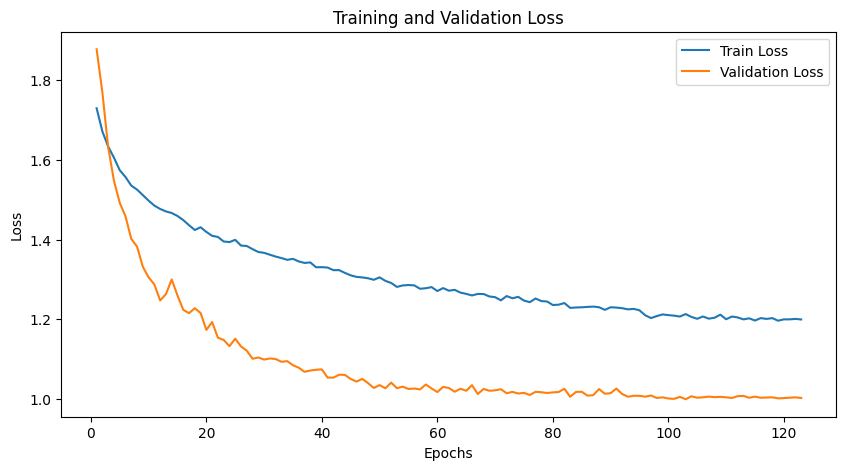

In [37]:
'''Now comes the most important part which is CNN model, after many many experimentation by checking overfitting ,
    underfitting and hyperparameter tuning, this model yielded best results'''
 '''I used batch normalization layer to stabilize gradient flow and training, added dropout to prevent overfitting'''
import matplotlib.pyplot as plt
import torch.optim as optim
# CNN model takes total number of classes and dropout parameter for initaliztion
class CNNModel(nn.Module):
    def __init__(self, num_classes, dropout):
        super(CNNModel, self).__init__()
        
        # Initialized all the Layers and params necessary , our model uses 4 convolutional layers and 2 dense layers 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)# Kept stride 1 for all  4 for maximum feature diversity retention
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 3 * 3, 128)  # dense layer to 128 output neurons
        self.fc2 = nn.Linear(128, num_classes) 
        self.mish =nn.Mish() # Used Mish , it outperformed ReLU and Swish for this dataset after much experimentation
        self.dropout = nn.Dropout(dropout)  # randomly dropout the neurons to make it robust against overfitting
        
    def forward(self, x):
        #Apply mish and batch normalization to all the convolutional layers and max pool it to reduce feature matrix dimension
        #conv1
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout(x)
        #conv2
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        #conv3
        x = self.mish(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        #conv4
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        #Dense layer
        x = x.view(-1, 256 * 3 * 3)  
        x = self.dropout(x)
        x = self.mish(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#our total classes =7
num_classes = 7 

# after careful iterations, learning rate , L2 regularization parameter and dropout parameter is set
learning_rate = 0.00005
L2_lambda=0.1
dropout=0.3
# Total Epochs to train our CNN model
epochs = 200

#Initialize our CNN model 
model = CNNModel(num_classes, dropout).to(device)
#Capture train and validation losses
train_losses = []
validation_losses = []

# Implemented Early stopping to prevent overfitting beyond the patience parameter
patience = 20
best_val_loss = float('inf')# keeps track of the best loss occured in our training
epochs_no_improve = 0 # keeps track of the total epochs which shown no improvement


# Loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor) # Use weights_tensor the Weighted Sampler to our cross entropy loss
criterion_val = nn.CrossEntropyLoss()# For validation we do not require the weighted Sampler

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)
# Used AdamW for optimizer

#Implemented Learning Rate Scheduler to reduce the learning rate by learning rate / e -1 for the 10 epochs

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, verbose=True)# verbose used for logging


# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    #Calculate accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion_val(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_loss = val_loss / len(test_loader)
    validation_losses.append(validation_loss)
    val_acc = 100 * correct / total
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {validation_loss}")
    
    # Check for early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_emotion_model.pth')
    else:
        epochs_no_improve += 1

    # Reduce learning rate if validation loss plateaus
    scheduler.step(validation_loss)

    if epochs_no_improve == patience:
        print('Early stopping!')
        break

print('Finished Training')
print(f'Accuracy on validation set: {val_acc} %')

# Load the best model
model.load_state_dict(torch.load('best_emotion_model.pth'))

# Plotting the train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [59]:
'''Accuracy is not enough when it comes to our imbalanced data, we need to gain better understanding how other
 metrics are for our dataset'''


from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score

#model = CNNModel(num_classes=7, dropout=0.3) #IF u want to directly evaluate it
model= model.load_state_dict(torch.load('best_emotion_model.pth'))
model.eval()

accuracy = 0
precision = 0
recall = 0
f1 = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Calculate precision, recall, F1-score (similar to validation loop)
        accuracy += accuracy_score(labels.cpu(), predicted.cpu())
        precision += precision_score(labels.cpu(), predicted.cpu(), average='weighted',zero_division=0)
        recall += recall_score(labels.cpu(), predicted.cpu(), average='weighted',zero_division=0)
        f1 += f1_score(labels.cpu(), predicted.cpu(), average='weighted')
        total += labels.size(0)

# Calculate average precision, recall, F1
accuracy = accuracy / len(test_loader)
precision = precision / len(test_loader)
recall = recall / len(test_loader)
f1 = f1 / len(test_loader)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')


# the metrics above are for all the classes, we need to create better understanding by evaluating Precision recall curve -
# and confusion matrix

Accuracy: 0.6371, Precision: 0.6689, Recall: 0.6371, F1-score: 0.6305


              precision    recall  f1-score   support

       Angry       0.54      0.59      0.56       960
     Disgust       0.61      0.61      0.61       111
        Fear       0.54      0.41      0.46      1018
       Happy       0.79      0.88      0.83      1825
     Neutral       0.57      0.57      0.57      1216
         Sad       0.51      0.49      0.50      1139
    Surprise       0.75      0.76      0.76       797

    accuracy                           0.64      7066
   macro avg       0.62      0.61      0.61      7066
weighted avg       0.63      0.64      0.63      7066



<Figure size 800x600 with 0 Axes>

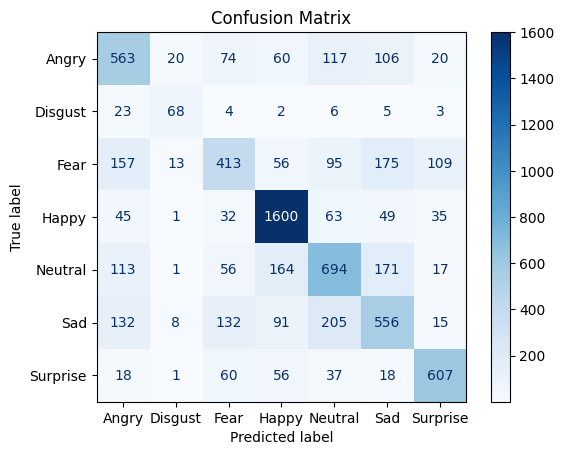

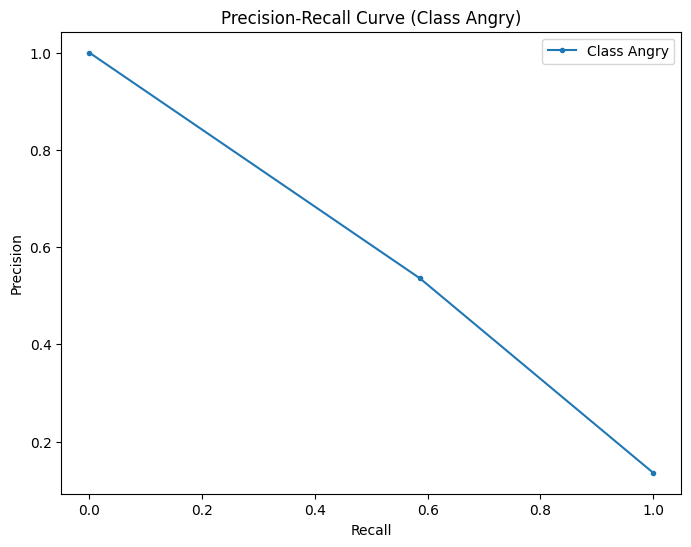

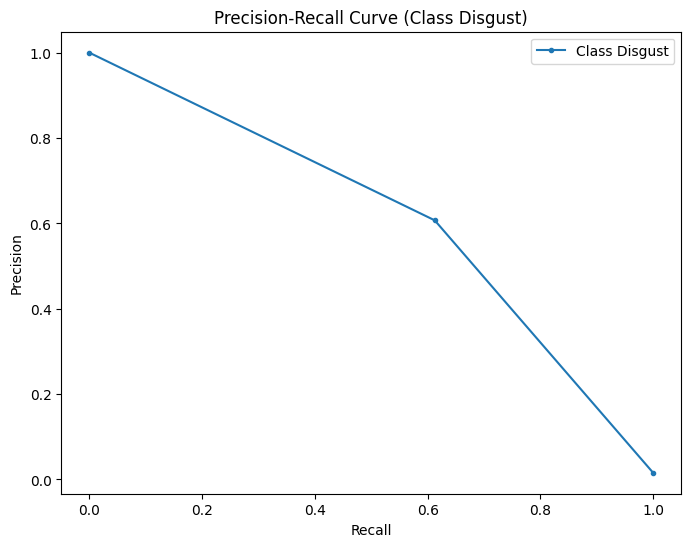

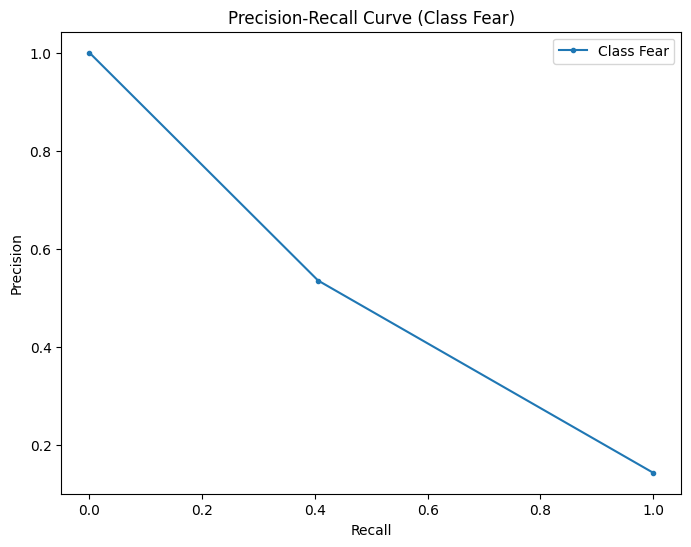

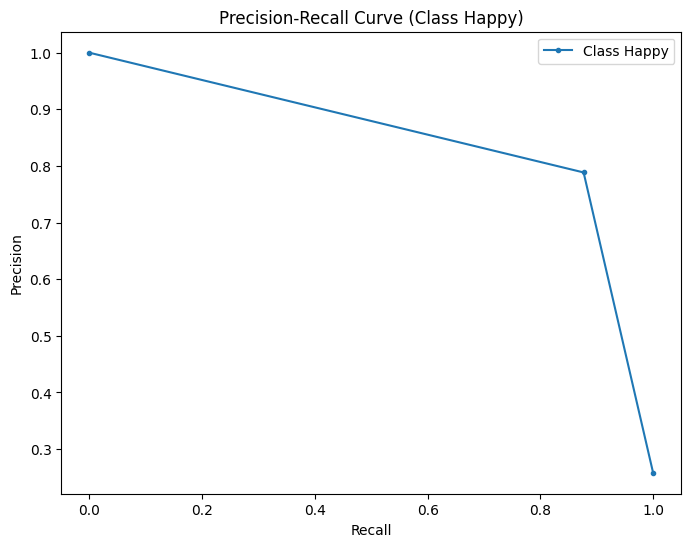

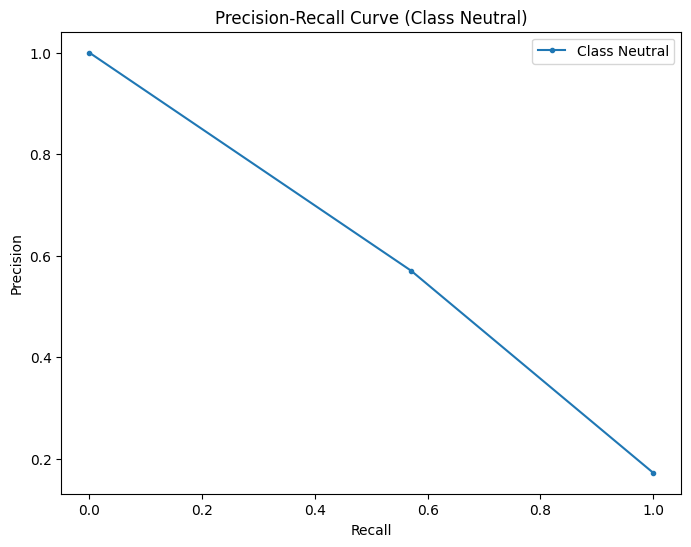

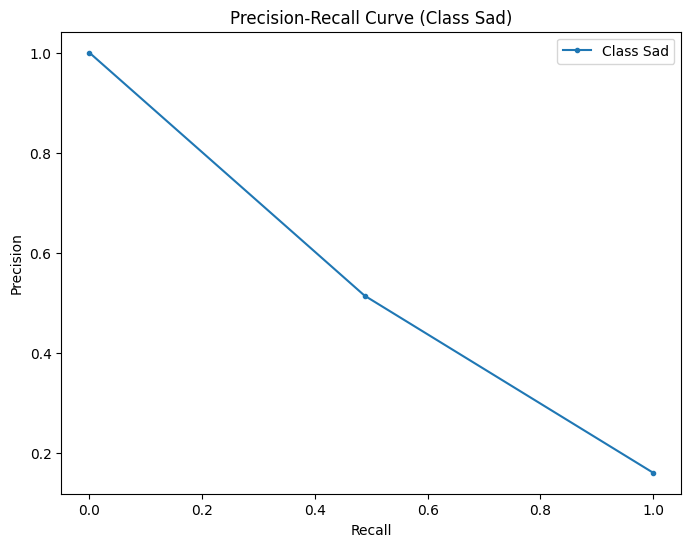

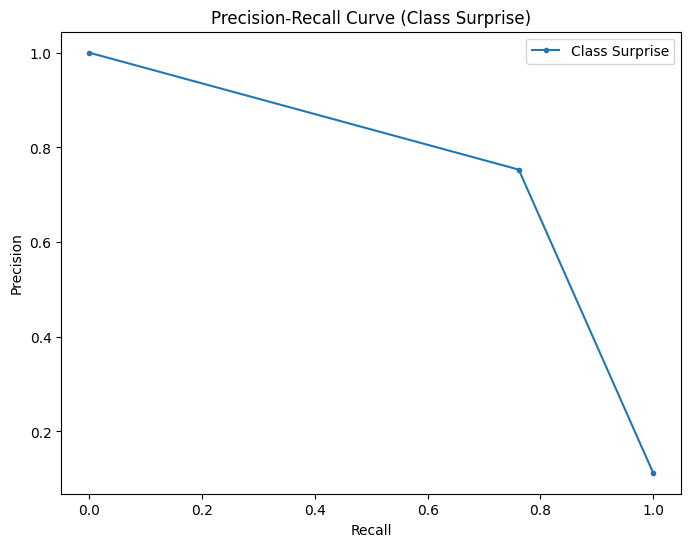

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(dataloader, device):
    class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']# mention our class labels
    # Store labels and predictions in list
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate precision, recall, and F1-score per class
    report = classification_report(all_labels, all_predictions, target_names=class_labels, output_dict=True)
    print(classification_report(all_labels, all_predictions, target_names=class_labels))  # Print full report

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix_disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot precision-recall curves for each class
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_predictions == i)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'Class {class_labels[i]}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (Class {class_labels[i]})')
        plt.legend()
        plt.show()


evaluate_model(test_loader, device)

'''We can see that Happy which had the most original samples performed well

Precision recall curve for each class is significant , where precision is predicted positive instances by our model 
that were actually positive,

recall states our model's capability to correctly classify the actual positive.


'''



              precision    recall  f1-score   support

       Angry       0.51      0.55      0.53       300
     Disgust       0.79      0.53      0.63       100
        Fear       0.52      0.38      0.44       300
       Happy       0.66      0.87      0.75       300
     Neutral       0.52      0.60      0.56       300
         Sad       0.46      0.44      0.45       300
    Surprise       0.83      0.74      0.78       300

    accuracy                           0.59      1900
   macro avg       0.61      0.59      0.59      1900
weighted avg       0.60      0.59      0.59      1900



<Figure size 800x600 with 0 Axes>

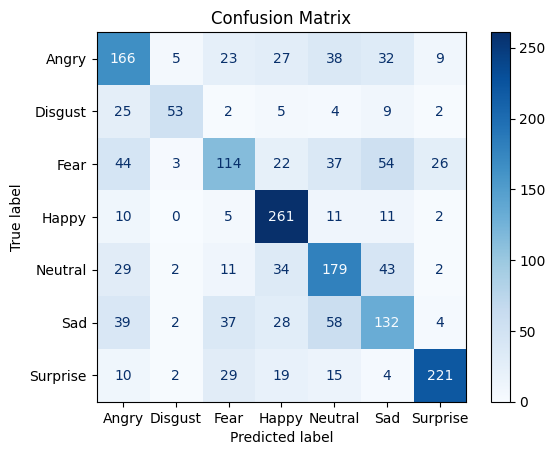

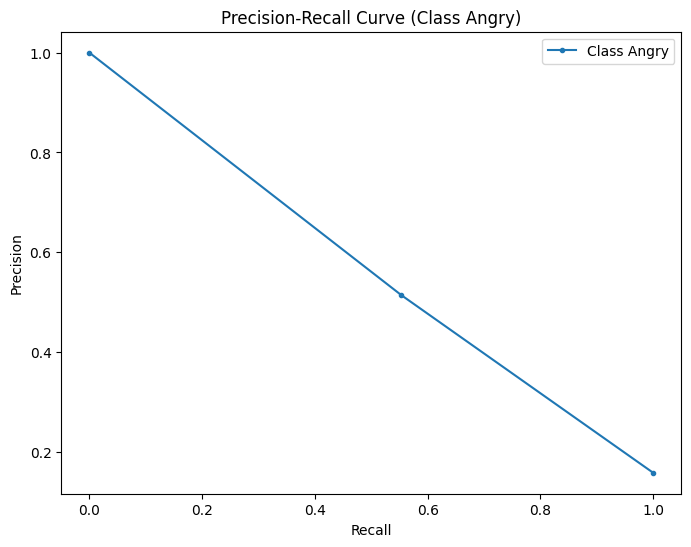

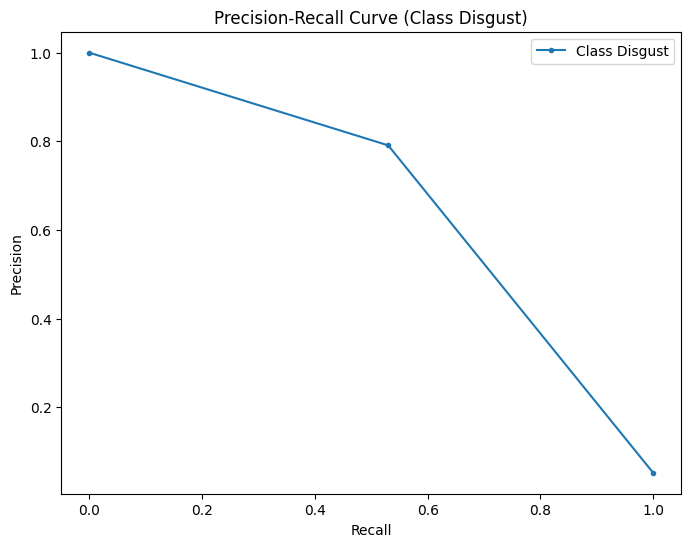

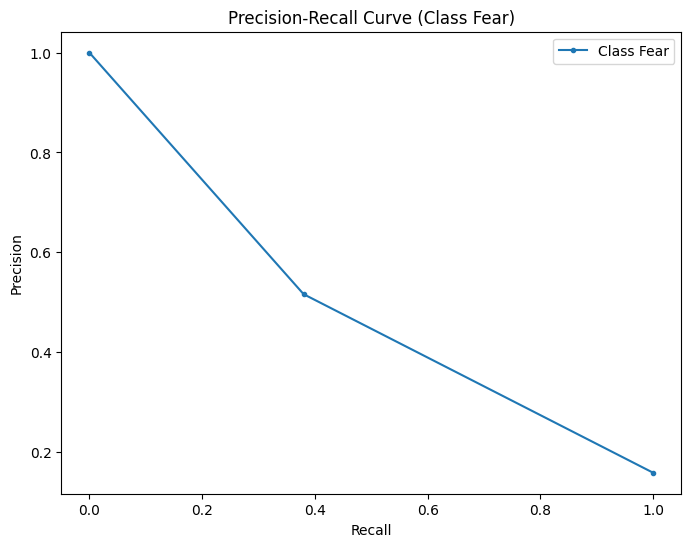

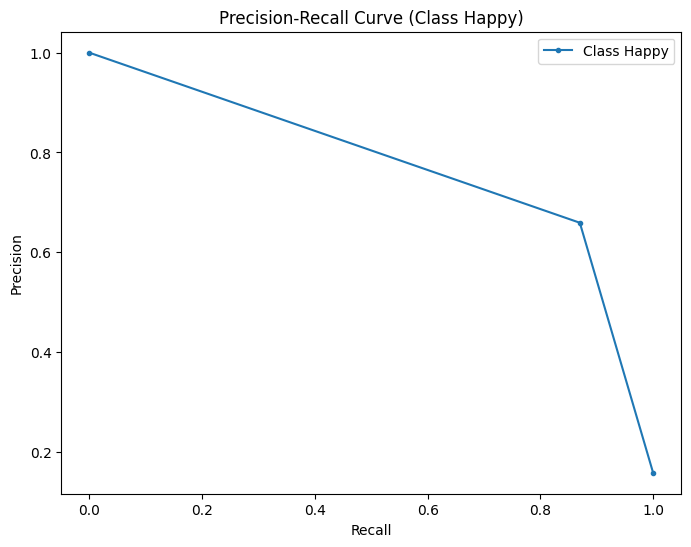

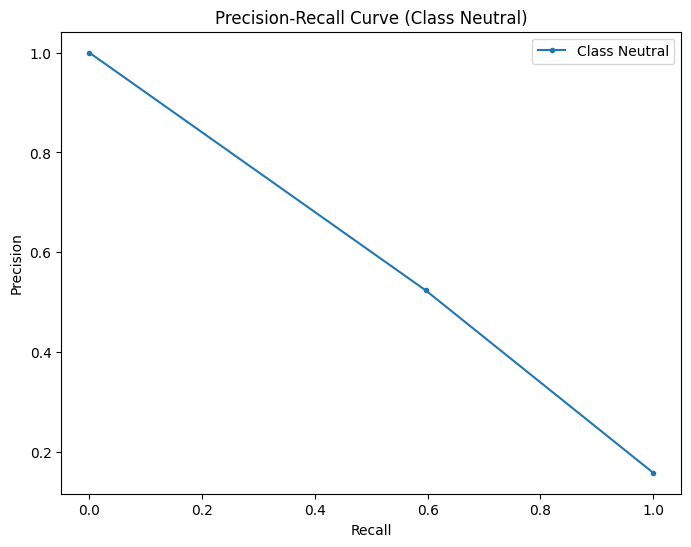

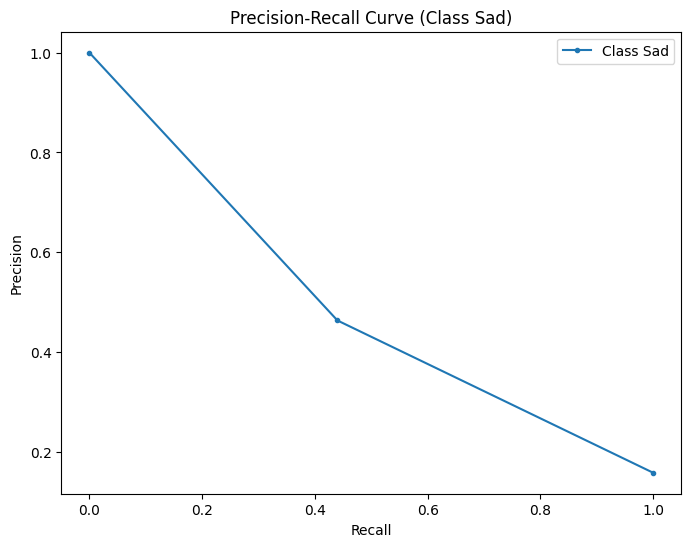

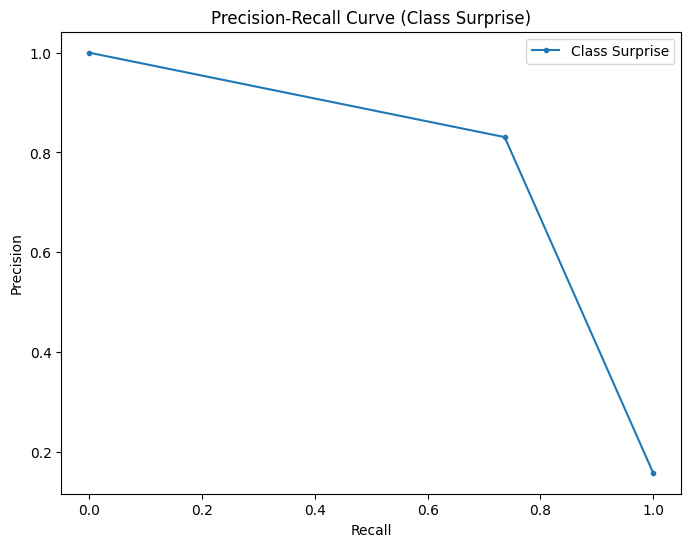

In [56]:
'''The above results were for the validation set where only Happy and Surprise performed well'''



#Lets test for out final_test folder which are completely unseen data, apply transformation and put to dataloader


final_test_data= datasets.ImageFolder(root='./images/final test', transform = basic_transform)
batch_size = len(final_test_data)
final_test_loader = DataLoader(final_test_data, batch_size=batch_size, shuffle=True)
evaluate_model(final_test_loader, device)

# CONCLUSION WITH FINAL_TEST RESULTS

### OUR MODEL DIDNT GENERALIZE WELL ON FEAR, ANGRY AND SAD AND NEUTRAL CLASSIFICATIONS

### THE MODEL PERFORMED DECENTLY FOR OUR MOST MINORITY CLASS 'DISGUST' BUT IT HAD VERY LOW RECALL , IT MISSED OUT ON ACTUAL IMAGES, BUT THE MODEL IS ABLE TO CORRECTLY CLASSIFY MOST POSITIVE PREDICTION FOR 'DISGUST


### THE MODEL PERFORMED WELL ON 'HAPPY' AND 'SURPRISE' CLASSES 

#### 'HAPPY': The class had good recall but lacks the precision causing higher false positive 
#### 'SURPRISE' : The class performed the best, with decent generalization and metrics


## Overall there is a lot of scope for improvement as the classes were heavily balanced. Further Model complexity can also be increased with careful tuning.


# THANK YOU.


